In [ ]:
!git clone https://github.com/makataomu/self_recognition.git
%cd self_recognition

Cloning into 'self_recognition'...
remote: Enumerating objects: 605, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 605 (delta 7), reused 16 (delta 2), pack-reused 580 (from 1)
Receiving objects: 100% (605/605), 57.89 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (358/358), done.
Updating files: 100% (301/301), done.
/content/self_recognition


In [ ]:
!git pull

Already up to date.


In [ ]:
import matplotlib.pyplot as plt
from data import load_data, save_to_json, load_from_json
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tabulate import tabulate
import pandas as pd
from itertools import zip_longest
from pandas import MultiIndex
import altair as alt

In [ ]:
from math import log
from scipy.stats import kendalltau

COLORS = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'grey', 'pink']

def avg(l):
    return sum(l) / len(l)

def brier_score(pred):
    return avg([(x - 1) ** 2 for x in pred])

def log_loss(pred):
    return -1 * avg([log(x) for x in pred])

def kendall_tau_for_results(model_results):
    detection_scores = [i['detection_score'] for i in model_results]
    self_preferences = [i['self_preference'] for i in model_results]

    return kendalltau(detection_scores, self_preferences).correlation

def kendall_tau(x, y):
    return kendalltau(x, y).correlation

MODEL_TO_STRING = {
    # 'claude': 'Claude 2.1',
    'human': 'Human',
    'gpt4': 'GPT-4 11/06',
    'gpt41_nano': 'GPT-4.1',
    # 'gpt35': 'Llama-2-7b-chat',
}

In [ ]:
DEBUG = True
STARTING_INDEX = 900

main_models = ['gpt4', 'gpt41_nano']

models = main_models

xsum_responses, xsum_articles, xsum_keys = load_data('xsum')
cnn_responses, cnn_articles, cnn_keys = load_data('cnn')

xsum_results = {}
cnn_results = {}
for model in models:
    xsum_results[model] = load_from_json(f'results/xsum/{model}_results.json')
    cnn_results[model] = load_from_json(f'results/cnn/{model}_results.json')
    if not DEBUG:
      if model in main_models:
          continue
    else:
      xsum_results[model] = [i for i in xsum_results[model] if i['key'] in xsum_keys[STARTING_INDEX:]]
      cnn_results[model] = [i for i in cnn_results[model] if i['key'] in cnn_keys[STARTING_INDEX:]]

# Individual setting results
xsum_detection_results = {}
xsum_score_results = {}
cnn_detection_results = {}
cnn_score_results = {}
for model in models:
    dataset = 'xsum'
    xsum_detection_results[model] = load_from_json(f'individual_setting_results/recognition_results/{dataset}/{model}_results.json')
    xsum_score_results[model] = load_from_json(f'individual_setting_results/score_results/{dataset}/{model}_results.json')
    dataset = 'cnn'
    cnn_detection_results[model] = load_from_json(f'individual_setting_results/recognition_results/{dataset}/{model}_results.json')
    cnn_score_results[model] = load_from_json(f'individual_setting_results/score_results/{dataset}/{model}_results.json')

    if not DEBUG:
      if model in main_models:
          continue
    else:
        xsum_detection_results[model] = [i for i in xsum_detection_results[model] if i['key'] in xsum_keys[STARTING_INDEX:]]
        xsum_score_results[model] = [i for i in xsum_score_results[model] if i['key'] in xsum_keys[STARTING_INDEX:]]
        cnn_detection_results[model] = [i for i in cnn_detection_results[model] if i['key'] in cnn_keys[STARTING_INDEX:]]
        cnn_score_results[model] = [i for i in cnn_score_results[model] if i['key'] in cnn_keys[STARTING_INDEX:]]

[Errno 2] No such file or directory: 'summaries/xsum_train_gpt35_responses.json'
[Errno 2] No such file or directory: 'summaries/xsum_train_llama_responses.json'
[Errno 2] No such file or directory: 'summaries/cnn_train_claude_responses.json'
[Errno 2] No such file or directory: 'summaries/cnn_train_gpt35_responses.json'
[Errno 2] No such file or directory: 'summaries/cnn_train_llama_responses.json'


In [ ]:
for result in xsum_score_results[model]:
  print(result)
  break

{'key': '36062480', 'model': 'gpt41_nano', 'target_model': 'human', 'scores': {'2': 0.9840932667697984, '1': 0.01590638619168411, '3': 3.411187840638711e-07, '4': 0, '5': 0}}


In [ ]:
def print_ambig_table(results):
    task = 'detection' # 'comparison
    task2 = 'comparison'
    table = [[model,
                            avg([result[f'forward_{task}'] == result[f'backward_{task}'] for result in results[model]]),
                            avg([result[f'forward_{task}'] == '1' and result[f'backward_{task}'] == '2' for result in results[model]]),
                            avg([result[f'forward_{task}'] == '2' and result[f'backward_{task}'] == '1' for result in results[model]]),

                            avg([result[f'forward_{task2}'] == result[f'backward_{task2}'] for result in results[model]]),
                            avg([result[f'forward_{task2}'] == '1' and result[f'backward_{task2}'] == '2' for result in results[model]]),
                            avg([result[f'forward_{task2}'] == '2' and result[f'backward_{task2}'] == '1' for result in results[model]]),
    ] for model in models]

    # table = [row + [row[2] / (row[2] + row[3]) if any(i != 0 for i in [row[2], row[3]]) else 0] for row in table]
    # table = [row + [row[5] / (row[5] + row[6]) if any(i != 0 for i in [row[2], row[3]]) else 0] for row in table]

    table = [row[0:1] + [round(i, 3) for i in row[1:]] for row in table]
    print(tabulate(table, headers = ['Model', 'Ambiguous', 'Correct', 'Incorrect', 'Ambiguous', 'Correct', 'Incorrect']))
    # print(tabulate(sorted())

print_ambig_table(cnn_results)

Model         Ambiguous    Correct    Incorrect    Ambiguous    Correct    Incorrect
----------  -----------  ---------  -----------  -----------  ---------  -----------
gpt4              0.388      0.588        0.025        0.072      0.882        0.045
gpt41_nano        0.34       0.46         0.2          0.22       0.575        0.205


In [ ]:
def print_zapped_table():
    table = [[model,
                        avg([result['detection_score'] for result in xsum_results[model]]),
                        avg([0.5 if result['detection_score'] == 0.5 else 1 if result['detection_score'] > 0.5 else 0 for result in xsum_results[model]]),

                        avg([result['self_preference'] for result in xsum_results[model]]),
                        avg([0.5 if result['self_preference'] == 0.5 else 1 if result['self_preference'] > 0.5 else 0 for result in xsum_results[model]]),

                        avg([result['detection_score'] for result in cnn_results[model]]),
                        avg([0.5 if result['detection_score'] == 0.5 else 1 if result['detection_score'] > 0.5 else 0 for result in cnn_results[model]]),

                        avg([result['self_preference'] for result in cnn_results[model]]),
                        avg([0.5 if result['self_preference'] == 0.5 else 1 if result['self_preference'] > 0.5 else 0 for result in cnn_results[model]]),

    ] for model in models]

    print(tabulate(sorted(table, key = lambda x: x[-1]), headers = ['Model', 'Self-Rec (XSUM)', 'Zapped', 'Self-Pref (XSUM)', 'Zapped', 'Self-Rec (CNN)', 'Zapped', 'Self-Pref (CNN)', 'Zapped']))
    # print(tabulate(sorted())

print_zapped_table()

Model         Self-Rec (XSUM)    Zapped    Self-Pref (XSUM)    Zapped    Self-Rec (CNN)    Zapped    Self-Pref (CNN)    Zapped
----------  -----------------  --------  ------------------  --------  ----------------  --------  -----------------  --------
gpt41_nano           0.701631     0.695            0.740749    0.745           0.630303      0.63           0.678995    0.69
gpt4                 0.657141     0.68             0.685573    0.7025          0.740217      0.88           0.915921    0.9325


In [ ]:
# Main pairwise results
table = [[model,
                    avg([result['detection_score'] for result in xsum_results[model]]),
                    avg([result['self_preference'] for result in xsum_results[model]]),

                    avg([result['detection_score'] for result in cnn_results[model]]),
                    avg([result['self_preference'] for result in cnn_results[model]]),
] for model in models]

table = [[row[0]] + [round(i, 3) for i in row[1:]] for row in table]
print(tabulate(table, headers = ['Model', 'Self-Rec', 'Self-Pref', 'Self-Rec', 'Self-Pref']))

Model         Self-Rec    Self-Pref    Self-Rec    Self-Pref
----------  ----------  -----------  ----------  -----------
gpt4             0.657        0.686        0.74        0.916
gpt41_nano       0.702        0.741        0.63        0.679


In [ ]:
task = 'detection'
task2 = 'comparison'
table = []
table += [[model,
                    avg([result[f'forward_{task}'] == result[f'backward_{task}'] for result in xsum_results[model]]),
                    avg([result[f'forward_{task}'] == '1' and result[f'backward_{task}'] == '2' for result in xsum_results[model]]),
                    avg([result[f'forward_{task}'] == '2' and result[f'backward_{task}'] == '1' for result in xsum_results[model]]),
                    avg([result['detection_score'] for result in xsum_results[model]]),

                    avg([result[f'forward_{task2}'] == result[f'backward_{task2}'] for result in xsum_results[model]]),
                    avg([result[f'forward_{task2}'] == '1' and result[f'backward_{task2}'] == '2' for result in xsum_results[model]]),
                    avg([result[f'forward_{task2}'] == '2' and result[f'backward_{task2}'] == '1' for result in xsum_results[model]]),
                    avg([result['self_preference'] for result in xsum_results[model]]),

                    kendall_tau_for_results(xsum_results[model]),

                    avg([result[f'forward_{task}'] == result[f'backward_{task}'] for result in cnn_results[model]]),
                    avg([result[f'forward_{task}'] == '1' and result[f'backward_{task}'] == '2' for result in cnn_results[model]]),
                    avg([result[f'forward_{task}'] == '2' and result[f'backward_{task}'] == '1' for result in cnn_results[model]]),
                    avg([result['detection_score'] for result in cnn_results[model]]),

                    avg([result[f'forward_{task2}'] == result[f'backward_{task2}'] for result in cnn_results[model]]),
                    avg([result[f'forward_{task2}'] == '1' and result[f'backward_{task2}'] == '2' for result in cnn_results[model]]),
                    avg([result[f'forward_{task2}'] == '2' and result[f'backward_{task2}'] == '1' for result in cnn_results[model]]),
                    avg([result['self_preference'] for result in cnn_results[model]]),

                    kendall_tau_for_results(cnn_results[model])
] for model in models]

table = [row + [row[2] / (row[2] + row[3]) if any(i != 0 for i in [row[2], row[3]]) else 0] for row in table] # Recognition Score (Ambig Removed) XSUM
table = [row + [row[6] / (row[6] + row[7]) if any(i != 0 for i in [row[6], row[7]]) else 0] for row in table] # Preference Score (Ambig Removed) XSUM

table = [row + [row[11] / (row[11] + row[12]) if any(i != 0 for i in [row[11], row[12]]) else 0] for row in table] # Recognition Score (Ambig Removed) CNN
table = [row + [row[15] / (row[15] + row[16]) if any(i != 0 for i in [row[15], row[16]]) else 0] for row in table] # Preference Score (Ambig Removed) CNN

print(tabulate(table))

----------  ------  ------  -----  --------  ------  ------  ----  --------  -------  ------  ------  -----  --------  ------  ------  -----  --------  --------  --------  --------  --------  --------
gpt4        0.3325  0.5175  0.15   0.657141  0.2375  0.5625  0.2   0.685573  0.70391  0.3875  0.5875  0.025  0.740217  0.0725  0.8825  0.045  0.915921  0.531729  0.775281  0.737705  0.959184  0.951482
gpt41_nano  0.245   0.6     0.155  0.701631  0.19    0.65    0.16  0.740749  0.70804  0.34    0.46    0.2    0.630303  0.22    0.575   0.205  0.678995  0.691558  0.794702  0.802469  0.69697   0.737179
----------  ------  ------  -----  --------  ------  ------  ----  --------  -------  ------  ------  -----  --------  ------  ------  -----  --------  --------  --------  --------  --------  --------


In [ ]:
results = xsum_results
print(tabulate(sorted([[model, avg([result['detection_score'] for result in results[model]]), avg([result['self_preference'] for result in results[model]]), kendall_tau_for_results(results[model])] for model in models], key = lambda x:x[1]), headers=['Model', 'Recog', 'Pref', 'Tau']))

Model          Recog      Pref      Tau
----------  --------  --------  -------
gpt4        0.657141  0.685573  0.70391
gpt41_nano  0.701631  0.740749  0.70804


In [ ]:
results = cnn_results
print(tabulate(sorted([[model, avg([result['detection_score'] for result in results[model]]), avg([result['self_preference'] for result in results[model]]), kendall_tau_for_results(results[model])] for model in models], key = lambda x:x[1]), headers=['Model', 'Recog', 'Pref', 'Tau']))

Model          Recog      Pref       Tau
----------  --------  --------  --------
gpt41_nano  0.630303  0.678995  0.691558
gpt4        0.740217  0.915921  0.531729


In [ ]:
# Print table showing the kendall_tau_for_result for cn and xsum on each main model
print(tabulate(sorted([[model, avg([result['detection_score'] for result in xsum_results[model]]), avg([result['self_preference'] for result in xsum_results[model]]), avg([result['detection_score'] for result in cnn_results[model]]), avg([result['self_preference'] for result in cnn_results[model]]),kendall_tau_for_results(xsum_results[model]), kendall_tau_for_results(cnn_results[model])] for model in models if 'llama' in model], key = lambda x:x[0]), headers=['Model', 'Self-Rec [X]', 'Self-Pref [X]', 'Self-Rec [C]', 'Self-Pref [C]', 'XSUM T', 'CNN T']))

Model    Self-Rec [X]    Self-Pref [X]    Self-Rec [C]    Self-Pref [C]    XSUM T    CNN T
-------  --------------  ---------------  --------------  ---------------  --------  -------


In [ ]:
def show_scatterplots(results, include_ambiguous=True):
    num_models = len(results.keys())

    plt.figure(figsize=(num_models * 6, num_models * 2))
    colors = ['blue', 'green', 'red']

    for i, model in enumerate(results.keys()):
        if not include_ambiguous:
            detection_scores = [i['detection_score'] for i in results[model] if i['forward_comparison'] != i['backward_comparison']]
            self_preferences = [i['self_preference'] for i in results[model] if i['forward_comparison'] != i['backward_comparison']]
        else:
            detection_scores = [i['detection_score'] for i in results[model]]
            self_preferences = [i['self_preference'] for i in results[model]]

        plt.subplot(1, 3, i+1)
        plt.scatter(detection_scores, self_preferences, color=colors[i])
        plt.xlabel('Detection Score')
        plt.ylabel('Self-Preference')
        plt.title(MODEL_TO_STRING[model])

    plt.suptitle('Detection Score vs Self-Preference (Token Probability)', fontsize=16, y=1)
    plt.tight_layout()
    plt.show()

In [ ]:
def show_scatterplots(results, include_ambiguous=True):
    num_models = len(results.keys())

    plt.figure(figsize=(num_models * 6, num_models * 2))
    colors = ['blue', 'green', 'red']

    for i, model in enumerate(results.keys()):
        if not include_ambiguous:
            detection_scores = [i['detection_score'] for i in results[model] if i['forward_comparison'] != i['backward_comparison']]
            self_preferences = [i['self_preference'] for i in results[model] if i['forward_comparison'] != i['backward_comparison']]
        else:
            detection_scores = [i['detection_score'] for i in results[model]]
            self_preferences = [i['self_preference'] for i in results[model]]

        plt.subplot(1, 3, i+1)
        plt.scatter(detection_scores, self_preferences, color=colors[i])
        plt.xlabel('Detection Score')
        plt.ylabel('Self-Preference')
        plt.title(MODEL_TO_STRING[model])

    plt.suptitle('Detection Score vs Self-Preference (Token Probability)', fontsize=16, y=1)
    plt.tight_layout()
    plt.show()

In [ ]:
def show_scatterplots_with_marginals(results, include_ambiguous=True):
    def is_valid(item):
        return 'detection_score' in item and 'self_preference' in item

    for i, model in enumerate(results.keys()):
        if not include_ambiguous:
            detection_scores = [item['detection_score'] for item in results[model] if is_valid(item) and item['forward_comparison'] != item['backward_comparison'] and item['forward_detection'] != item['backward_detection']]
            self_preferences = [item['self_preference'] for item in results[model] if is_valid(item) and item['forward_comparison'] != item['backward_comparison'] and item['forward_detection'] != item['backward_detection']]
        else:
            detection_scores = [item['detection_score'] for item in results[model] if is_valid(item)]
            self_preferences = [item['self_preference'] for item in results[model] if is_valid(item)]

        # Create a jointplot for each model
        joint_plot = sns.jointplot(x=detection_scores, y=self_preferences, kind="scatter", color=COLORS[i % len(COLORS)], marginal_kws=dict(bins=15, fill=True))

        joint_plot.ax_joint.set_xlim(0, 1.0)
        joint_plot.ax_joint.set_ylim(0, 1.0)

        # Adjust the title position and font size
        joint_plot.fig.suptitle(f'{MODEL_TO_STRING[model]}', fontsize=14, y=1.05)
        # joint_plot.fig.suptitle(f'Detection Score vs Self-Preference (Token Probability) for {MODEL_TO_STRING[model]}', fontsize=14, y=1.05)

        # Adjust axis labels font size
        joint_plot.set_axis_labels('Detection Score', 'Self-Preference', fontsize=12)

        # Show the plot
        plt.savefig(f'plots/scatterplots/xsum/{model}.png', bbox_inches='tight')
        plt.show()


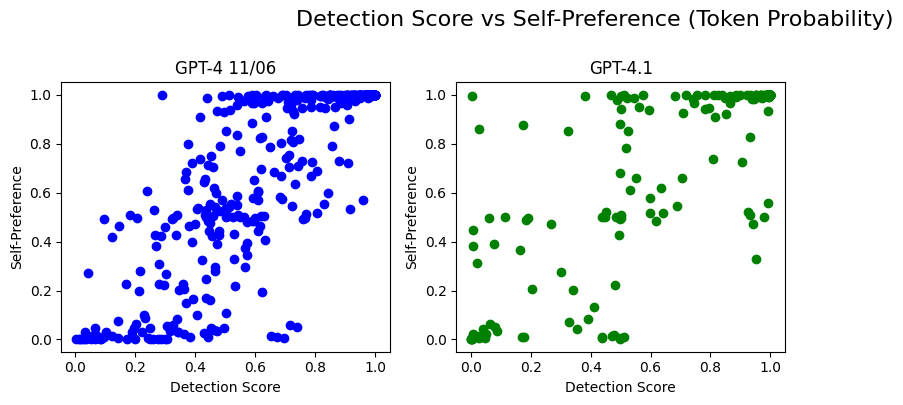

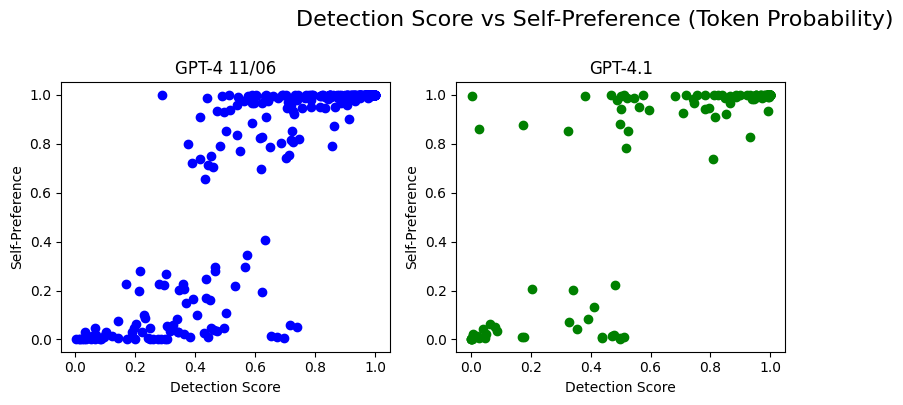

In [ ]:
show_scatterplots(results)
show_scatterplots(results, include_ambiguous=False)

In [ ]:
def show_heatmaps(results, include_ambiguous=True):
    num_models = len(results.keys())

    plt.figure(figsize=(num_models * 6, num_models * 2))
    colors = ['blue', 'green', 'red', 'orange']

    for i, model in enumerate(results.keys()):
        if not include_ambiguous:
            detection_scores = [i['detection_score'] for i in results[model] if i['forward_comparison'] != i['backward_comparison']]
            self_preferences = [i['self_preference'] for i in results[model] if i['forward_comparison'] != i['backward_comparison']]
        else:
            detection_scores = [i['detection_score'] for i in results[model]]
            self_preferences = [i['self_preference'] for i in results[model]]

        plt.subplot(1, num_models, i+1)
        plt.hexbin(detection_scores, self_preferences, gridsize=30, cmap='Blues')
        plt.colorbar(label='Density')
        plt.xlabel('Detection Score')
        plt.ylabel('Self-Preference')
        plt.title(MODEL_TO_STRING[model])

    plt.suptitle('Detection Score vs Self-Preference (Token Probability)', fontsize=16, y=1)
    plt.tight_layout()
    plt.show()

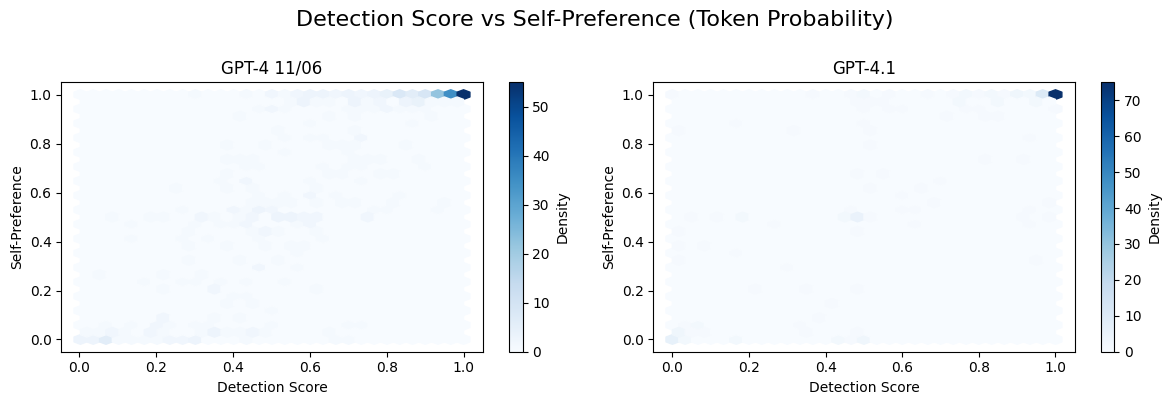

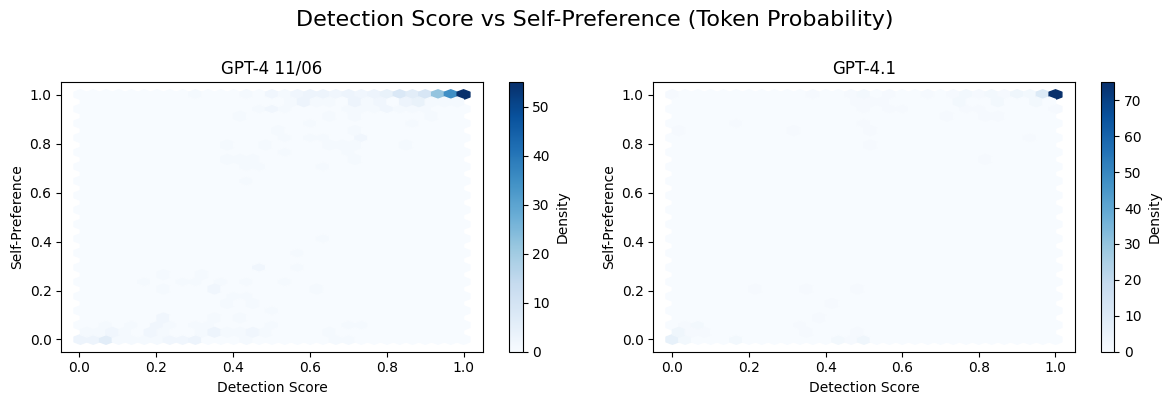

In [ ]:
show_heatmaps(results)
show_heatmaps(results, include_ambiguous=False)

In [ ]:
def plot_detection_score_vs_correlation(*results_dicts):
    # Extract 'a' and 'b' values
    x_values = []
    y_values = []
    plot_models = []
    d = {}
    for results in results_dicts:
        keys = [model for model in models if any(s in model for s in ['_2_ft_', '_10_ft_', '_500_ft_'])] #list(results.keys())
        plot_models += keys
        x_values += [avg([i['detection_score'] for i in results[key] if 'detection_score' in i]) for key in keys]
        y_values += [avg([i['self_preference'] for i in results[key] if 'self_preference' in i]) for key in keys]
        y_values += [kendall_tau_for_results(results[key]) for key in keys]
        for key in keys:
            d[key] = [(i['detection_score'], i['self_preference']) for i in results[key] if 'detection_score' in i and 'self_preference' in i]

    save_to_json(d, 'xsum_plot_data.json')
    # Create a scatter plot
    plt.figure(figsize=(8, 8))

    # Generate a color map with a unique color for each point
    markers = (['o'] * 3 + ['^'] * 3) * 4
    colors = ['red'] * 12 + ['blue'] * 12
    # colors = ['red', 'blue', 'green', 'orange', 'yellow', 'purple', 'black', 'pink', 'grey'][:len(plot_models)]

    # Plot each point
    print(plot_models)
    for i, (a, b, color, marker) in enumerate(zip_longest(x_values, y_values, colors, markers)):
        plt.scatter(a, b, color=color, marker=marker, label=MODEL_TO_STRING[plot_models[i]])

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')

    # Create a legend below the plot in a vertical column
    plt.legend(title="Key", loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=1)

    # Add grid, title, and axis labels
    plt.grid(True)
    # plt.title('Detection Score vs. Self-Preference')
    plt.xlabel('Self-Recognition Score')
    plt.ylabel("Self-Preference")

    # Show the plot
    plt.savefig(f'plots/xsum_scaling_law.png', bbox_inches='tight')
    plt.show()
    return zip(plot_models, x_values, y_values)

In [ ]:
# plot_detection_score_vs_correlation([cnn_results, xsum_results])

---------------------------XSUM------------------------------


/tmp/ipython-input-74-1434800798.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='pastel')


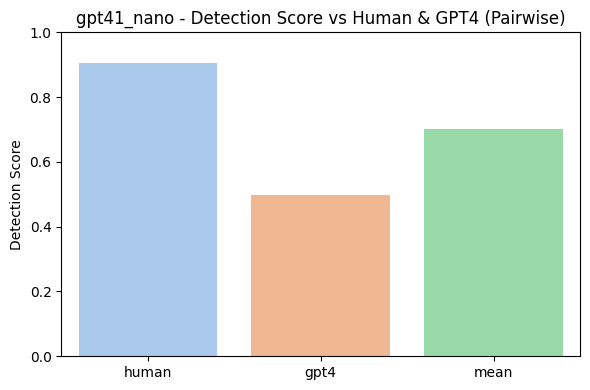

/tmp/ipython-input-74-1434800798.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='muted')


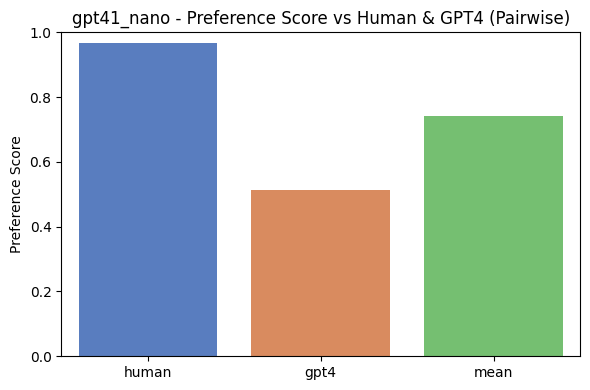

/tmp/ipython-input-74-1434800798.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='Set2')


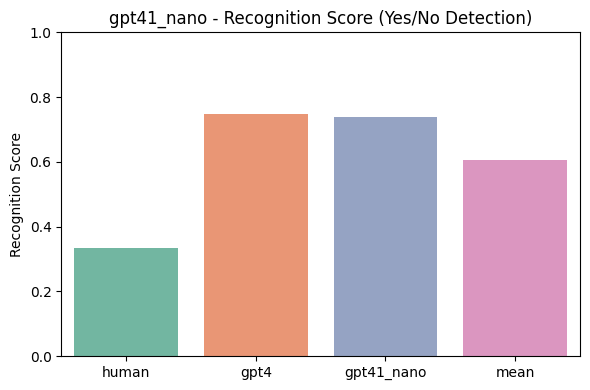

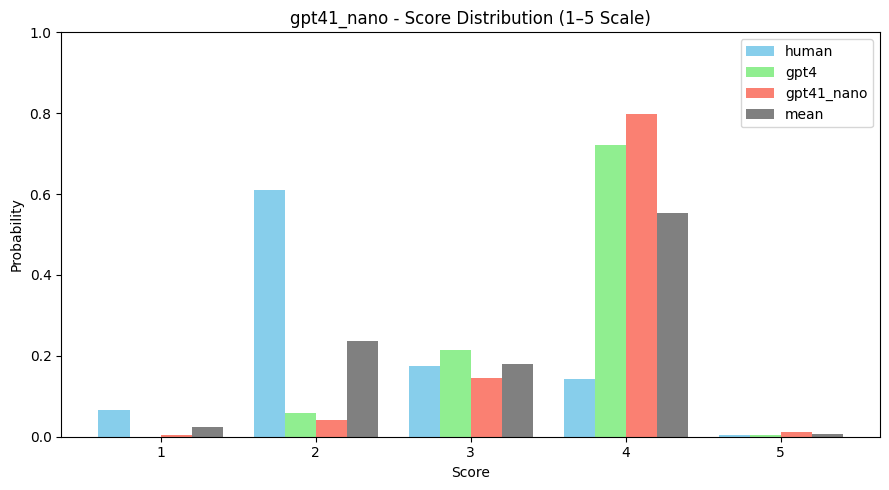

---------------------------CNN------------------------------


/tmp/ipython-input-74-1434800798.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='pastel')


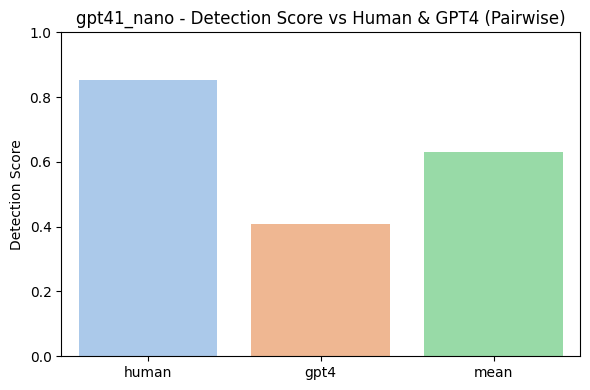

/tmp/ipython-input-74-1434800798.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='muted')


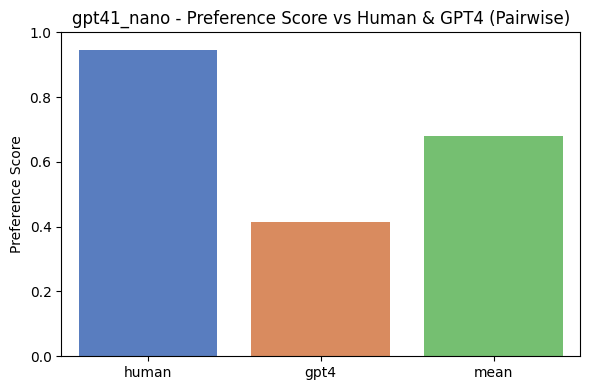

/tmp/ipython-input-74-1434800798.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='Set2')


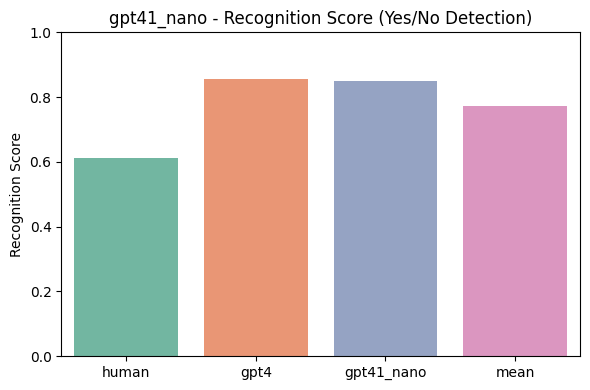

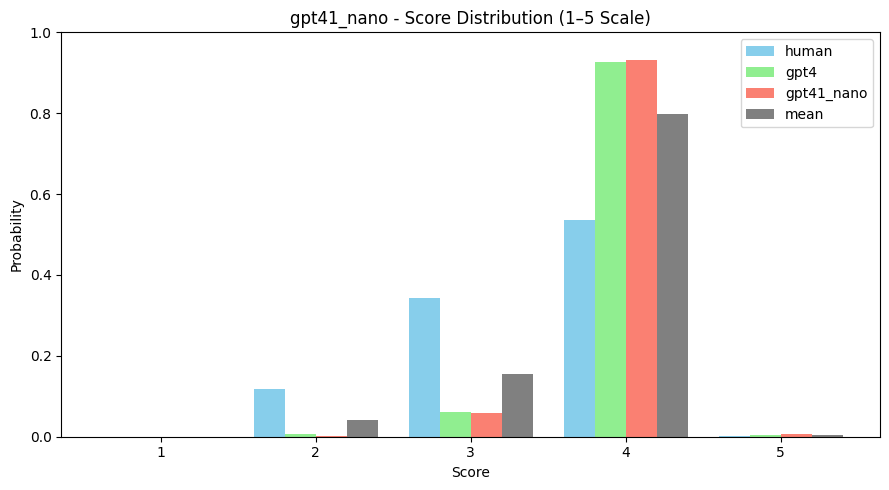

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

# Utility function
def average_score_dicts(dicts):
    total = defaultdict(float)
    count = defaultdict(int)
    for d in dicts:
        for k, v in d.items():
            total[k] += v
            count[k] += 1
    all_keys = set(total.keys())
    avg = {k: total[k] / count[k] for k in all_keys}
    return avg

def avg(values):
    return sum(values) / len(values) if values else 0

# Data definitions
model = 'gpt41_nano'

dataset_results = xsum_results.copy()
dataset_detection_results = xsum_detection_results.copy()
dataset_score_results = xsum_score_results.copy()

for dataset_results, dataset_detection_results, dataset_score_results, name in zip(
    [xsum_results, cnn_results],
     [xsum_detection_results, cnn_detection_results],
      [xsum_score_results, cnn_score_results],
       ['XSUM', 'CNN']):
  ### PLOT 1: Detection Scores (Pairwise)
  print(f"---------------------------{name}------------------------------")
  plt.figure(figsize=(6, 4))
  labels = ['human', 'gpt4']
  scores = [
      avg([item['detection_score'] for item in dataset_results[model] if item['model'] == 'human']),
      avg([item['detection_score'] for item in dataset_results[model] if item['model'] == 'gpt4']),
  ]
  scores.append(avg(scores))  # Add mean
  labels.append('mean')
  sns.barplot(x=labels, y=scores, palette='pastel')
  plt.title(f'{model} - Detection Score vs Human & GPT4 (Pairwise)')
  plt.ylabel('Detection Score')
  plt.ylim(0, 1)
  plt.tight_layout()
  plt.show()

  ### PLOT 2: Self-Preference Scores (Pairwise)
  plt.figure(figsize=(6, 4))
  labels = ['human', 'gpt4']
  scores = [
      avg([item['self_preference'] for item in dataset_results[model] if item['model'] == 'human']),
      avg([item['self_preference'] for item in dataset_results[model] if item['model'] == 'gpt4']),
  ]
  scores.append(avg(scores))
  labels.append('mean')
  sns.barplot(x=labels, y=scores, palette='muted')
  plt.title(f'{model} - Preference Score vs Human & GPT4 (Pairwise)')
  plt.ylabel('Preference Score')
  plt.ylim(0, 1)
  plt.tight_layout()
  plt.show()

  ### PLOT 3: Recognition Scores (Individual Detection)
  plt.figure(figsize=(6, 4))
  labels = ['human', 'gpt4', 'gpt41_nano']
  scores = [
      avg([item['recognition_score'] for item in dataset_detection_results[model] if item['target_model'] == 'human']),
      avg([item['recognition_score'] for item in dataset_detection_results[model] if item['target_model'] == 'gpt4']),
      avg([item['recognition_score'] for item in dataset_detection_results[model] if item['target_model'] == 'gpt41_nano']),
  ]
  scores.append(avg(scores))
  labels.append('mean')
  sns.barplot(x=labels, y=scores, palette='Set2')
  plt.title(f'{model} - Recognition Score (Yes/No Detection)')
  plt.ylabel('Recognition Score')
  plt.ylim(0, 1)
  plt.tight_layout()
  plt.show()

  ### PLOT 4: Score Distribution (1–5 Scale)
  plt.figure(figsize=(9, 5))
  ratings = ['1', '2', '3', '4', '5']
  targets = ['human', 'gpt4', 'gpt41_nano']
  score_matrix = []

  for target in targets:
      score_dicts = [item['scores'] for item in dataset_score_results[model] if item['target_model'] == target]
      avg_scores = average_score_dicts(score_dicts)
      score_matrix.append([avg_scores.get(r, 0) for r in ratings])

  # Add mean across targets
  score_matrix_np = np.array(score_matrix)
  mean_scores = score_matrix_np.mean(axis=0)
  score_matrix.append(mean_scores.tolist())
  target_labels = ['human', 'gpt4', 'gpt41_nano', 'mean']

  x = np.arange(len(ratings))
  width = 0.2

  colors = ['skyblue', 'lightgreen', 'salmon', 'gray']
  for i in range(4):
      plt.bar(x + width*(i - 1.5), score_matrix[i], width, label=target_labels[i], color=colors[i])

  plt.xticks(x, ratings)
  plt.title(f'{model} - Score Distribution (1–5 Scale)')
  plt.ylabel('Probability')
  plt.xlabel('Score')
  plt.legend()
  plt.ylim(0, 1)
  plt.tight_layout()
  plt.show()
